# Pluri-Gaussian

<!-- SUMMARY: Pluri-Gaussian simulations performed in 2D -->

<!-- CATEGORY: Methodology -->

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import os

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

## Prepare the basic gstlearn objects

Initial objects are located in a specific Directory which is defined in the next Container operation. Note that his operation will modify automatically all the names of the Files retreived using Serialize / Deserialize operation (not when reading using CSV). Also note that the Container name must be ended using a "/" (as its serves as a Directory).

In [2]:
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN,ndim)

### Load the data file

This Load is performed starting from a CSV file.

In [3]:
filename = gdoc.loadData("BRGM", "Nitrates_LANU.csv")
datCat = pd.read_csv(filename,sep=";")
datCat.head()

,X,Y,LANU,HyGeo,NO3,BG
0,428575.6629,5.541444e+06,2,1,0.5,-99.0
1,431573.6549,5.542124e+06,2,1,150.0,-99.0
2,431565.6549,5.542160e+06,2,1,150.0,-99.0
3,435820.6447,5.543920e+06,3,1,78.0,-99.0
4,435955.6443,5.543910e+06,3,1,64.0,-99.0


### Loading polygon from a file

The polygon is created by deserializing the Neutral Polygon File

In [4]:
filename = gdoc.loadData("BRGM", "poly_LANU.ascii")
poly = gl.Polygons.createFromNF(filename)
poly


Polygons
--------
Number of Polygon Sets = 1

### Creation of the gstlearn data base 

In [5]:
dat = gl.Db()
fields = ["X","Y","LANU"]
dat[fields] = datCat[fields].values

###  Specification of the role of each variable (named "locators" in gstlearn)

In [6]:
dat.setLocators(["X","Y"],gl.ELoc.X) #Coordinates
dat.setLocator("LANU",gl.ELoc.Z) #Variable of interest
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 1691

Variables
---------
Column = 0 - Name = X - Locator = x1
Column = 1 - Name = Y - Locator = x2
Column = 2 - Name = LANU - Locator = z1

### Creation of the output grid

The output grid will contain 47 x 101 nodes. It is built to cover the data file plus an extension of 10000 x 10000.

In [7]:
Result = gl.DbGrid.createCoveringDb(dat,[47,101],[],[],[50000,50000])

### Add a selection (mask the cells outside the polygon)

The initial selection (based on the application of the Polygon to the grid data base) must be dilated in order to avoid edge effect.

In [8]:
gl.db_polygon(Result,poly)
Result.setLocator("Polygon",gl.ELoc.Z)
Result.morpho(gl.EMorpho.DILATION,0.5,1.5,option=0,verbose=False,radius=[1,1])
Result["Polygon"]=Result["Morpho.Polygon.*"]
Result.deleteColumn("Morpho.Polygon.*")
Result.setLocator("Polygon",gl.ELoc.SEL)

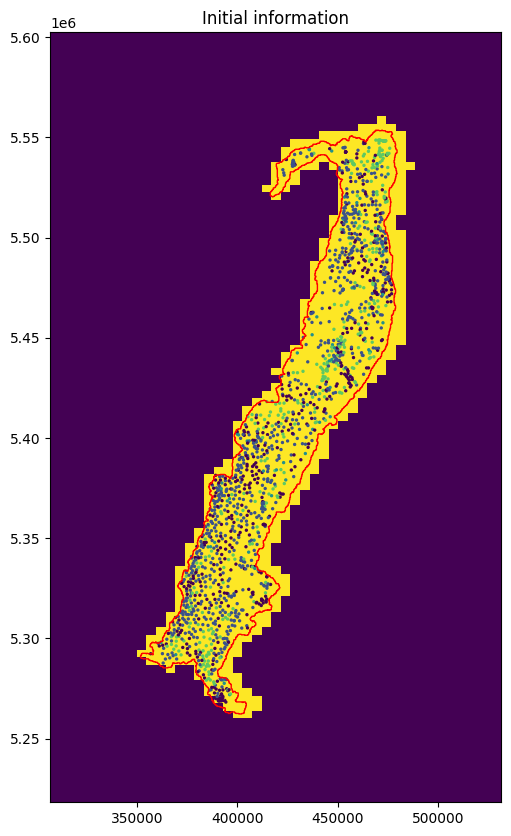

In [9]:
ax = Result.plot(nameRaster="Polygon",useSel=False,flagLegendRaster=False)
ax.gstpoint(dat,nameColor="LANU",size=2)
ax.polygon(poly,linewidth=1,edgecolor="r")
ax.geometry(dims=[10,10])
ax.decoration(title="Initial information")

## Computation of the proportions

### Compute global proportions (for information)

In [10]:
propGlob = gl.dbStatisticsFacies(dat)
ncat = len(propGlob)
for i in range(ncat):
    print("Proportion of facies "+str(i+1),"=",propGlob[i])

Proportion of facies 1 = 0.2726197516262567
Proportion of facies 2 = 0.46954464813719693
Proportion of facies 3 = 0.046126552335895916
Proportion of facies 4 = 0.205204021289178
Proportion of facies 5 = 0.006505026611472502


### Compute local proportions

The next parts will be simplified in a future dedicated API

**2.2.1 Creation of the spatial regularization model for proportions**

In [11]:
model = gl.Model.createFromDb(Result)
cova = gl.CovAniso.createIsotropic(model.getContext(),gl.ECov.BESSEL_K,range=50000.,param=2.,sill=1.,) 
model.addCov(cova)

In [12]:
err = gl.db_proportion_estimate(dat,Result,model)

In [13]:
dbfmt = gl.DbStringFormat()
dbfmt.setFlags(flag_stats=True)
dbfmt.setNames(["Prop.*"])
Result.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 8
Total number of samples      = 4747
Number of active samples     = 752

Grid characteristics:
---------------------
Origin : 306764.2835218227.694
Mesh   :   4787.785  3803.924
Number :         47       101

Data Base Statistics
--------------------
4 - Name Prop.1 - Locator p1
 Nb of data          =       4747
 Nb of active values =        752
 Minimum value       =      0.000
 Maximum value       =      0.867
 Mean value          =      0.218
 Standard Deviation  =      0.162
 Variance            =      0.026
5 - Name Prop.2 - Locator p2
 Nb of data          =       4747
 Nb of active values =        752
 Minimum value       =      0.000
 Maximum value       =      0.934
 Mean value          =      0.415
 Standard Deviation  =      0.257
 Variance            =      0.066
6 - Name Prop.3 - Locator p3
 Nb of data     

### Display the results

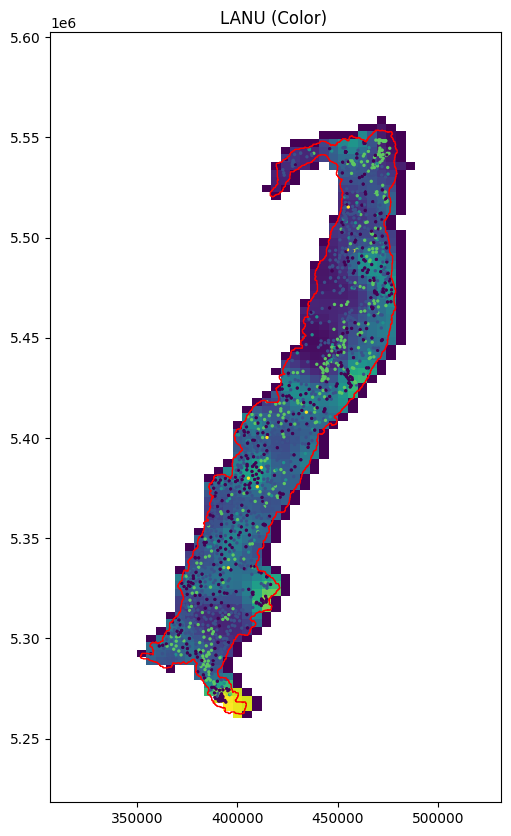

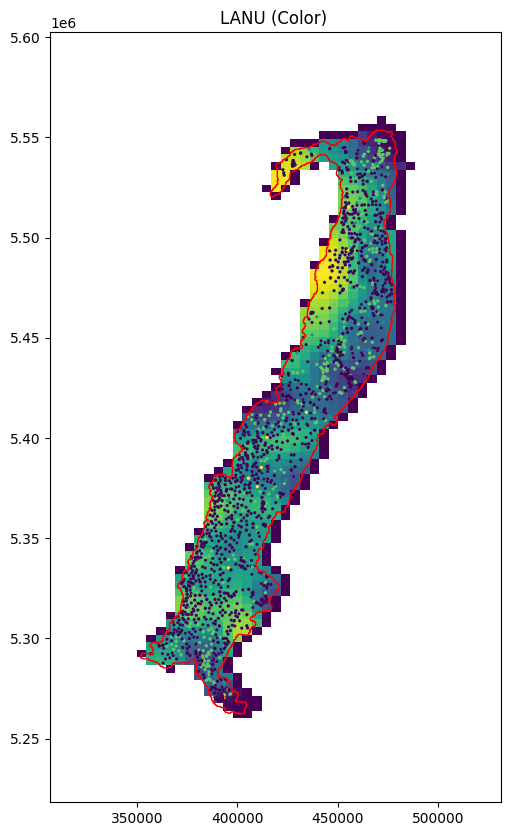

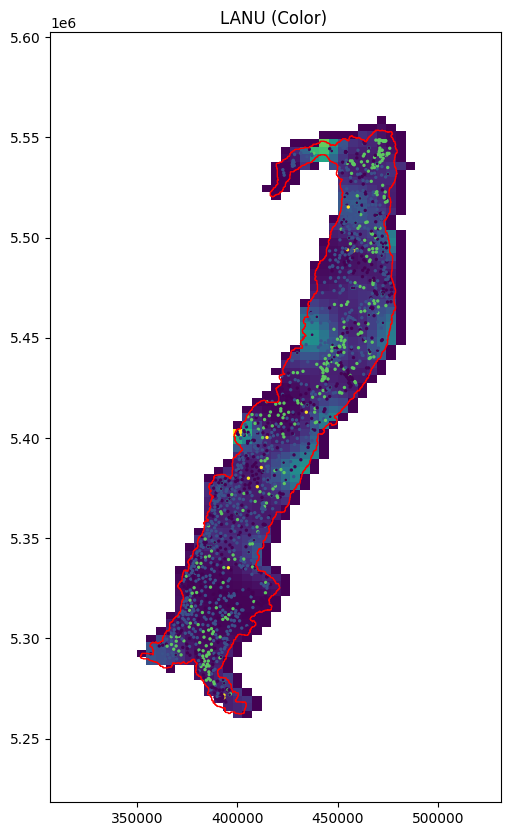

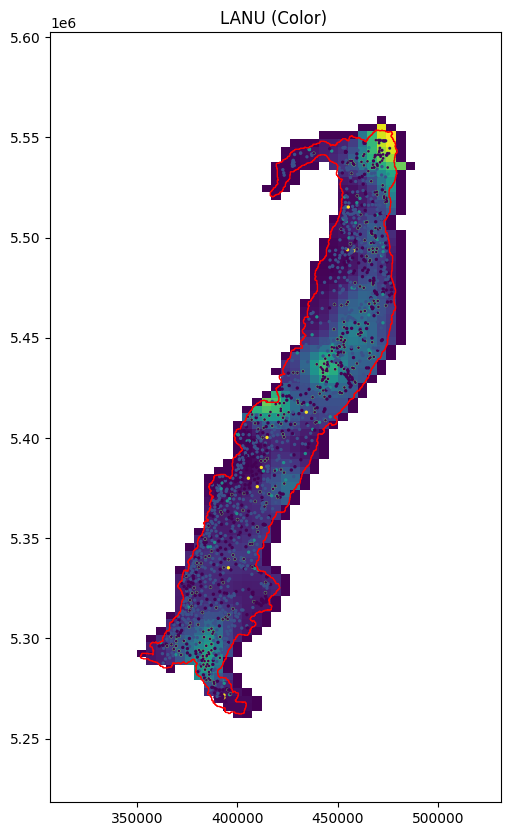

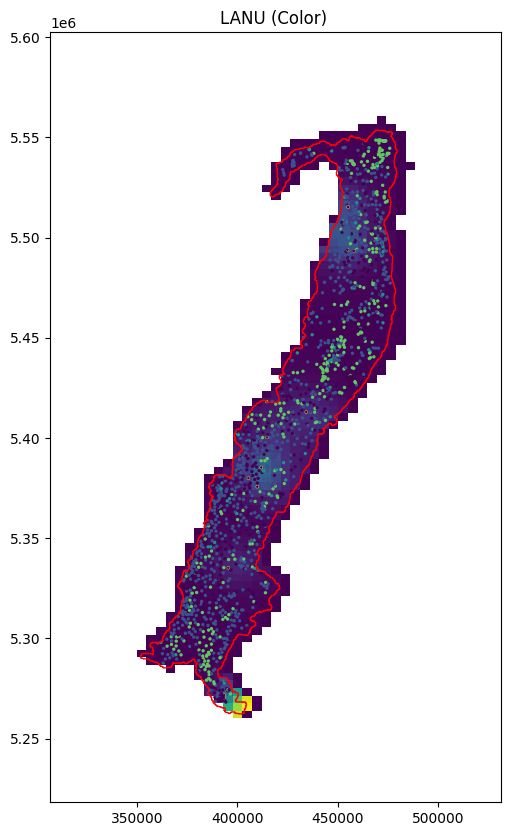

In [14]:
for i in range(ncat):
    fig, ax = plt.subplots()
    ax = Result.plot(nameRaster="Prop."+str(i+1))
    ax.decoration(title="Proportion Facies #"+str(i+1))
    ax.geometry(dims=[10,10], aspect=1)
    ax.gstpoint(dat,nameColor="LANU",size=2,color="black")
    dat.addSelectionByLimit("LANU",gl.Limits((i+1,i+1)),"SelPoint")
    ax.gstpoint(dat,nameColor="LANU",size=0.8,color="red")
    dat.deleteColumn("SelPoint")
    ax.polygon(poly,linewidth=1,edgecolor="r")

Creating the environment to infer the Rule. It uses a variogram calculated over very few lags close to the origin.

In [15]:
varioParam = gl.VarioParam()
dirparam = gl.DirParam.create(npas = 2, dpas=100)
varioParam.addDir(dirparam);
ruleprop = gl.RuleProp.createFromDb(Result);
ruleprop.fit(dat, varioParam, 1);
ngrf = ruleprop.getRule().getGRFNumber()
print("Number of GRF =",ngrf)

Number of GRF = 1


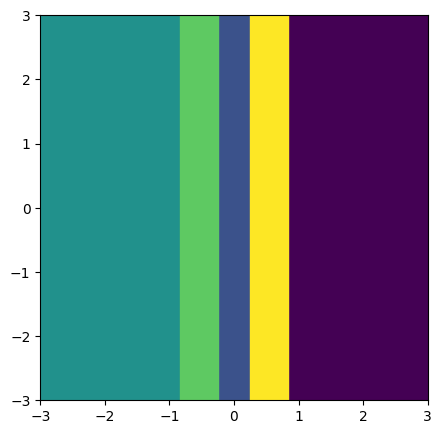

In [16]:
ax=ruleprop.getRule().plot()

In [17]:
dirparam = gl.DirParam.create(npas = 19, dpas=1000)
covparam = gl.VarioParam();
covparam.addDir(dirparam);
cov = gl.variogram_pgs(dat,covparam,ruleprop);

In [18]:
cov.display()


Non-centered Covariance characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 2
Variance-Covariance Matrix     1.000

Direction #1
------------
Number of lags              = 19
Direction coefficients      =      1.000     0.000
Direction angles (degrees)  =      0.000
Tolerance on direction      =     90.000 (degrees)
Calculation lag             =   1000.000
Tolerance on distance       =     50.000 (Percent of the lag value)

For variable 1
      Rank    Npairs  Distance     Value
       -19  9732.000 17998.608     0.017
       -18  9506.000 17006.901    -0.017
       -17  8885.000 16006.927    -0.017
       -16  8815.000 15002.837    -0.017
       -15  8068.000 14003.176     0.000
       -14  8019.000 12999.786     0.000
       -13  7684.000 12002.331    -0.052
       -12  7363.000 11000.802    -0.017
       -11  6935.000 10007.370    -0.039
       -10  6310.000  9006.739    -0.039
        -9  5975.000  8003.635    -0.039
      

We extract the experimental variograms of each GRF.

In [19]:
vario1 = gl.Vario.createReduce(cov,[0],[],True)
if ngrf > 1:
    vario2 = gl.Vario(cov)
    vario2.resetReduce([1],[],True)

In [20]:
vario1.display()
if ngrf > 1:
    vario2.display()


Variogram characteristics
Number of variable(s)       = 1
Number of direction(s)      = 1
Space dimension             = 2
Variance-Covariance Matrix     1.000

Direction #1
------------
Number of lags              = 19
Direction coefficients      =      1.000     0.000
Direction angles (degrees)  =      0.000
Tolerance on direction      =     90.000 (degrees)
Calculation lag             =   1000.000
Tolerance on distance       =     50.000 (Percent of the lag value)

For variable 1
      Rank    Npairs  Distance     Value
         0   238.000   307.621     0.240
         1  1290.000  1055.802     0.747
         2  2345.000  2038.996     0.906
         3  3011.000  3019.326     1.000
         4  3682.000  4012.782     1.073
         5  4397.000  5019.156     1.000
         6  5035.000  6014.805     1.039
         7  5615.000  7013.830     1.017
         8  5975.000  8003.635     1.039
         9  6310.000  9006.739     1.039
        10  6935.000 10007.370     1.039
        11  7363.000

We now fit the model of each GRF considered as independent. 

The fit is performed under the constraint that the sill should be 1.

In [21]:
ctxt = gl.CovContext(1,2) # use default space
constraints = gl.Constraints()
constraints.setConstantSillValue(1.)
covs  = [gl.ECov.BESSEL_K]

modelPGS1 = gl.Model(ctxt)
modelPGS1.fit(vario1,covs,constraints)
modelPGS1.display()

if ngrf > 1:
    modelPGS2 = gl.Model(ctxt)
    modelPGS2.fit(vario2,covs,constraints)
    modelPGS2.display()
else:
    modelPGS2 = None


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
K-Bessel (Third Parameter = 0.791416)
- Sill         =      1.000
- Range        =   1815.867
- Theo. Range  =    589.238
Total Sill     =      1.000
Known Mean(s)     0.000


For each GRF, we can plot the experimental variogram as well as the fitted model.

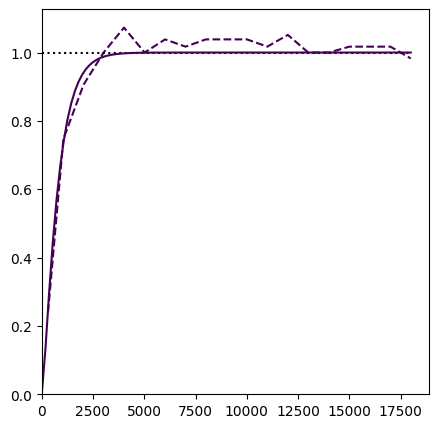

In [22]:
ax = gp.varmod(vario1,modelPGS1)
if ngrf > 1:
    ax = gp.varmod(vario2,modelPGS2)

In this paragraph, we compare the experimental indicator variogram to the one derived from the Model of the underlying GRFs.

In [23]:
dirparamindic = gl.DirParam.create(npas=19, dpas=1000)
varioparamindic = gl.VarioParam()
varioparamindic.addDir(dirparamindic)
varioindic = gl.Vario(varioparamindic)
err = varioindic.computeIndic(dat)

In [24]:
varioindic2 = gl.model_pgs(dat, varioparamindic, ruleprop, modelPGS1, modelPGS2);

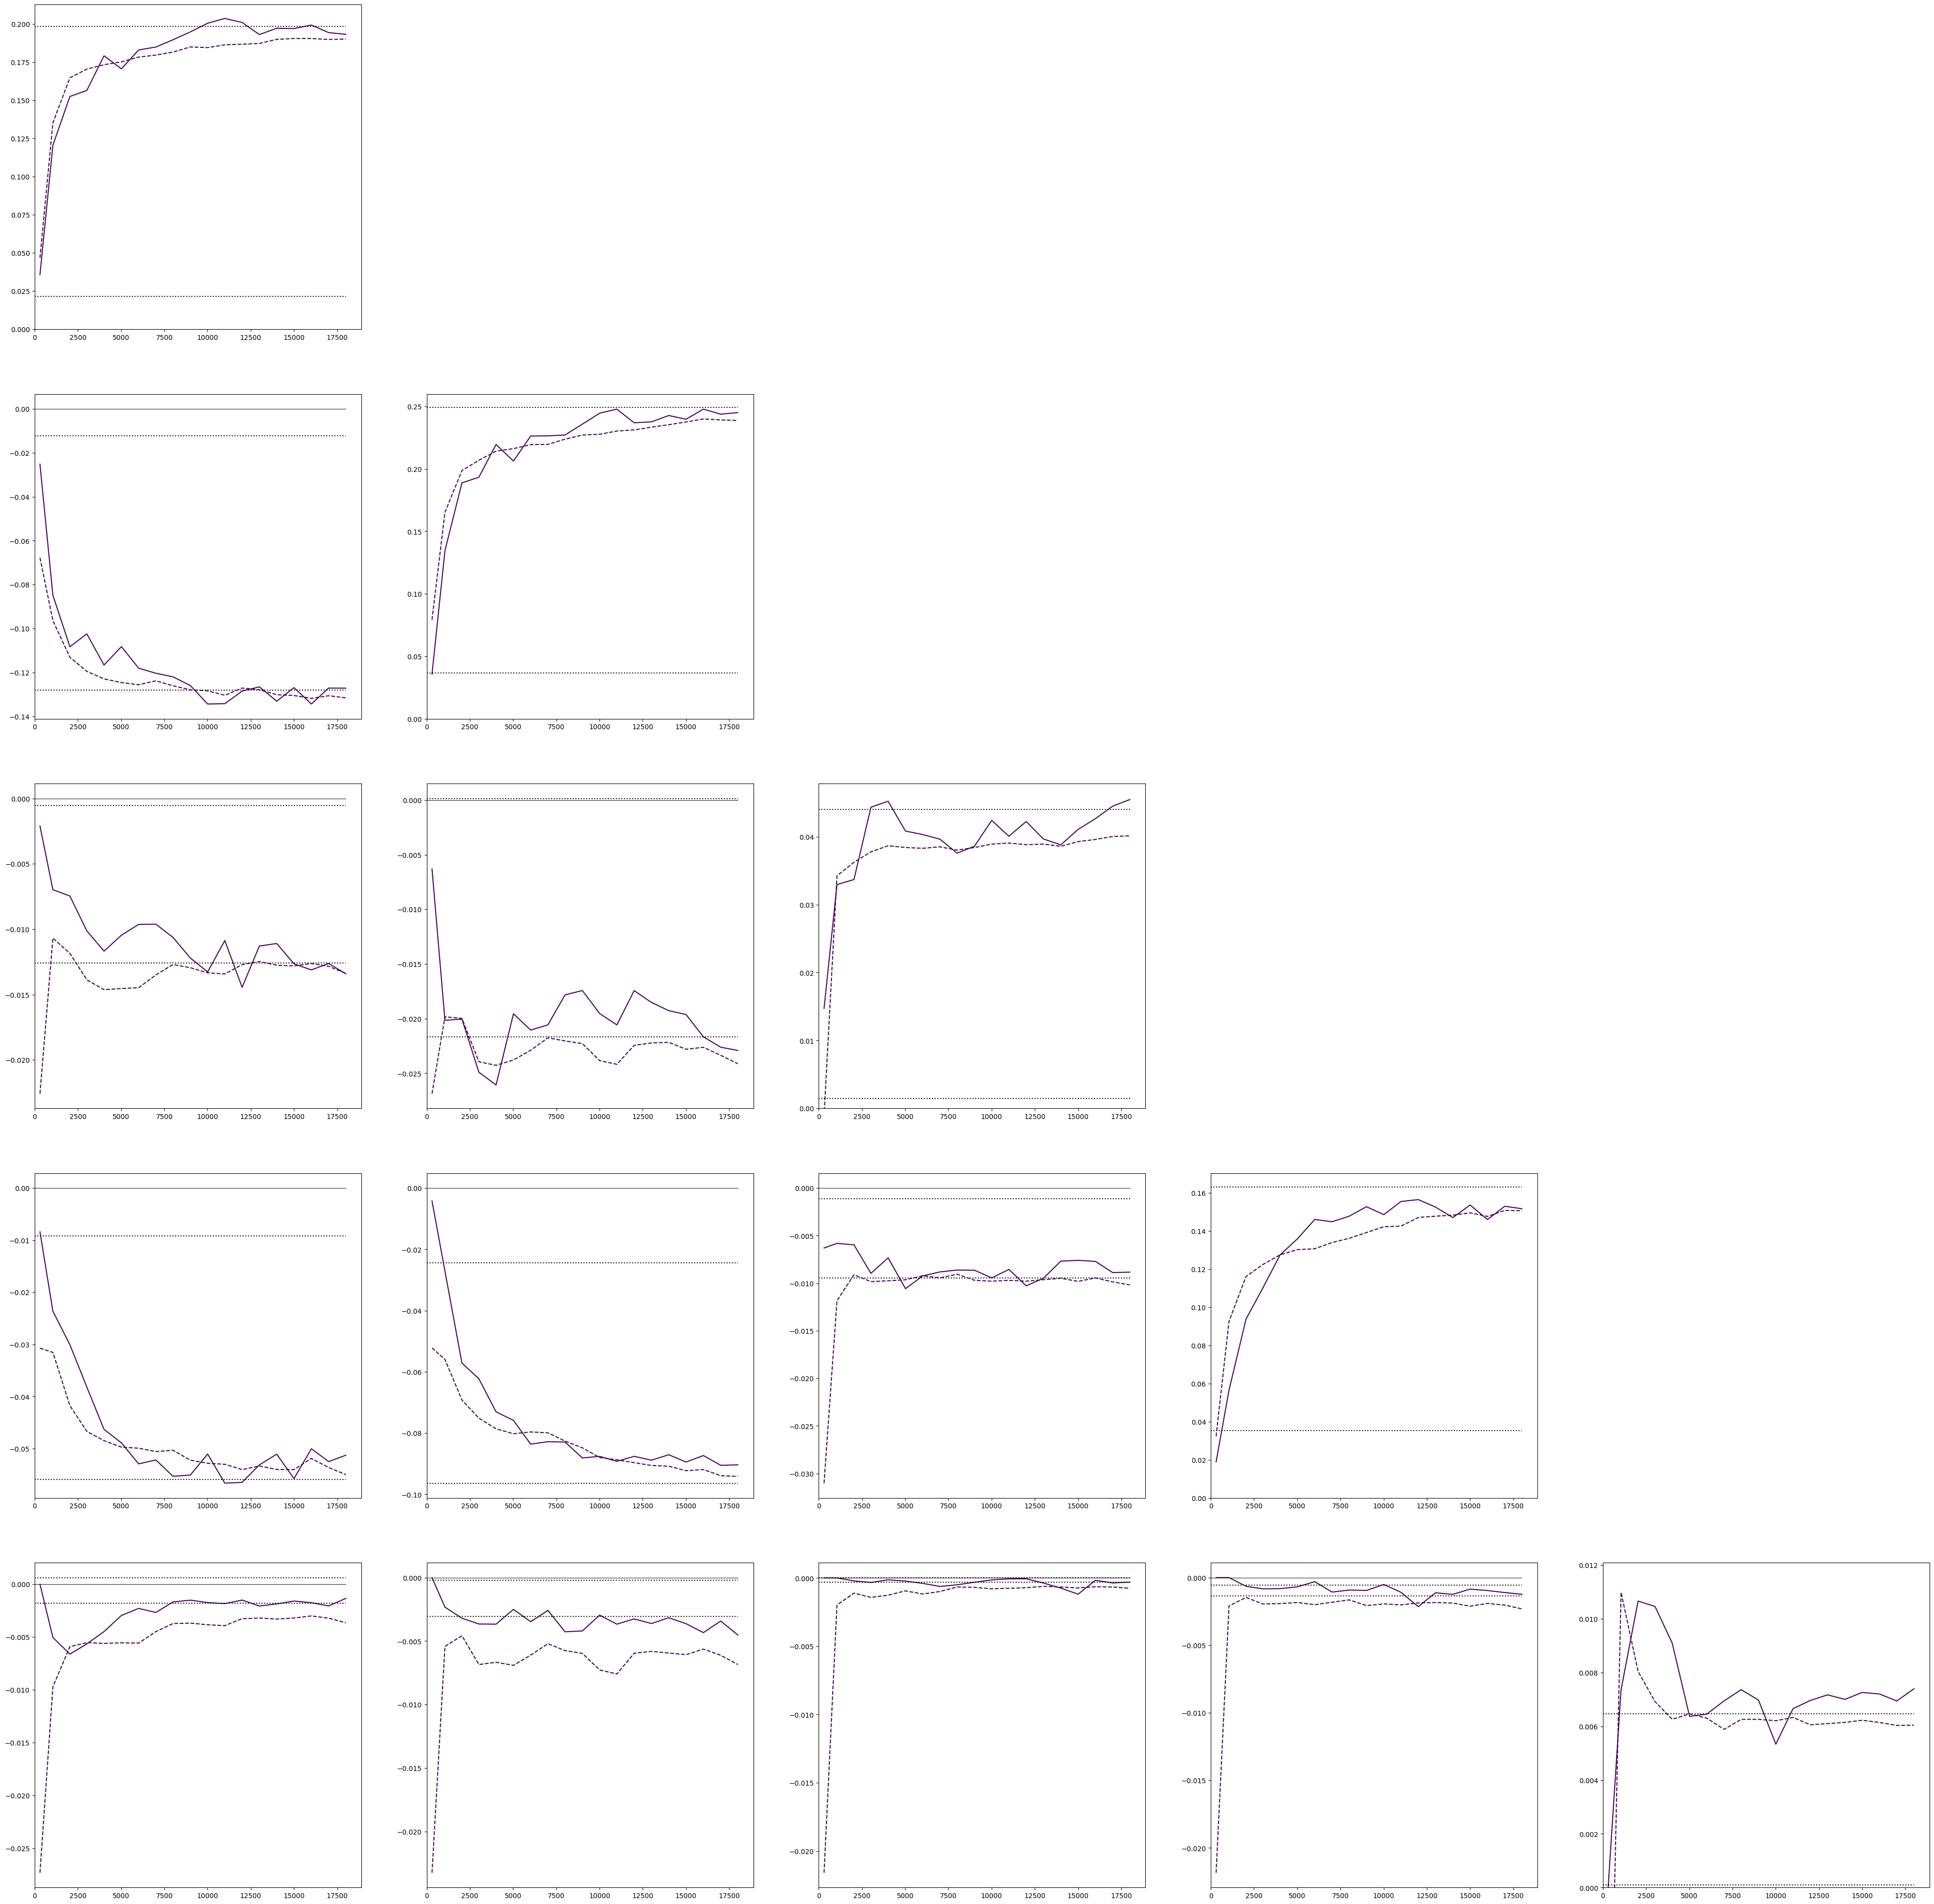

In [25]:
axs = gp.varmod(varioindic,varioLinestyle='solid')
gp.geometry(axs,dims=[10,10])
axs = gp.varmod(varioindic2,varioLinestyle='dashed',axsOld=axs)

In [26]:
neigh = gl.NeighUnique.create()
err = gl.simpgs(dat,Result,ruleprop,modelPGS1,modelPGS2,neigh)

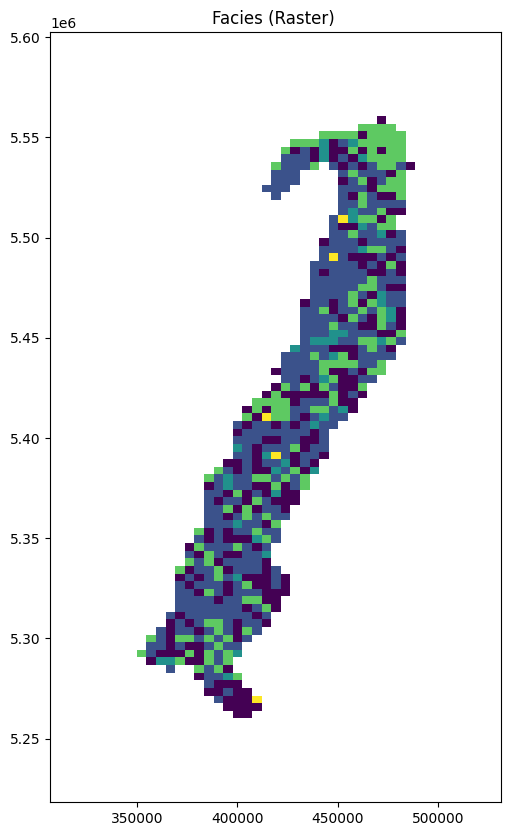

In [27]:
ax = Result.plot()
ax.geometry(dims=[10,10])